# Using Price Providers

In [1]:
from simple_back import price_providers

In [2]:
prices = price_providers.YahooFinanceProvider()

In [3]:
prices['AAPL','2015-1-2','open']

101.82906658545272

In [4]:
prices['AAPL',:,'open'][:5]

1980-12-12    0.405683
1980-12-15    0.386281
1980-12-16    0.358060
1980-12-17    0.365115
1980-12-18    0.375698
dtype: float64

In [5]:
prices['AAPL'][:5]

,open,high,low,close,adjclose,volume,ticker
1980-12-12,0.513393,0.515625,0.513393,0.513393,0.405683,117258400.0,AAPL
1980-12-15,0.488839,0.488839,0.486607,0.486607,0.384517,43971200.0,AAPL
1980-12-16,0.453125,0.453125,0.450893,0.450893,0.356296,26432000.0,AAPL
1980-12-17,0.462054,0.464286,0.462054,0.462054,0.365115,21610400.0,AAPL
1980-12-18,0.475446,0.477679,0.475446,0.475446,0.375698,18362400.0,AAPL


# Backtesting
### Price
Use ``price`` to get the current price of a symbol. Given a number, it will go back that amount of days, which can be used to compute averages, etc.
### Available Capital & Capital
While ``capital`` is the current value of your portfolio + cash, ``available_capital`` is capital not tied up in securities only.
### Order
Use ``order`` to enter a long trade of the given ticker, using the given funds (either use an absolute number or a percentage when passing ``as_percent=True``). To enter a short position, pass ``short=True``.
### Portfolio
``portfolio`` is a dataframe that contains information about all currently held positions.
### Liquidate
Use ``liquidate`` to get out of positions. Simply pass a filter for ``portfolio`` and all entries matching it will be liquidated.

In [6]:
from simple_back.backtester import Backtester
from datetime import date
from tqdm.auto import tqdm

## Iterator
The backtester object can be iterated over to run simple strategies.
It exposes ``day`` (e.g. 2010-01-01), ``event`` ('open' or 'close') and itself.

In [7]:
bt = Backtester(10_000, prices, market_calendar='NYSE', start_date='2019-1-1', end_date=date.today())
ticker = 'QQQ'
for day, event, b in tqdm(bt):
    # calculate average price of the ticker over the last 30 days
    avg = b.price(ticker,30).mean()
    # liquidate all positions with the ticker symbol
    b.liquidate(b.portfolio['symbol']==ticker)
    # enter long position if the price is higher than the mean of the last 30 days
    if b.price(ticker) > avg:
        b.order(ticker, 1, as_percent=True)
    # do the opposite if the price is lower
    if b.price(ticker) < avg:
        b.order(ticker, b.available_capital, short=True)

## Plotting

In [8]:
import matplotlib.pyplot as plt

### Values
``values`` tracks the value of the backtest over time.

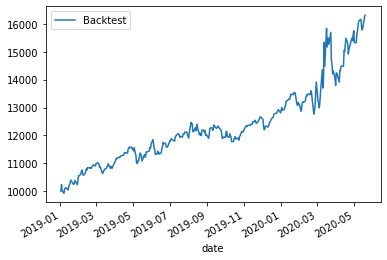

In [9]:
bt.values.plot()
plt.show()

### Compare
``compare`` constructs a dataframe which combines ``values`` with the returns of one or more other securities.

E.g. ``bt.compare(['AAPL','MSFT'])`` compares our backtest's returns with the returns had we invested in Microsoft or Apple instead.

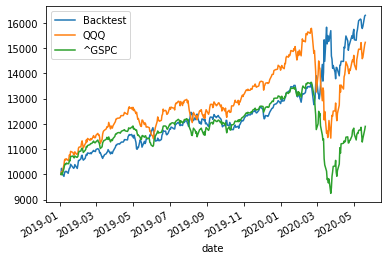

In [10]:
bt.compare(['QQQ','^GSPC']).plot()
plt.show()

In [11]:
import seaborn as sns

### Profit Loss
``profit_loss`` contains daily profit loss values.

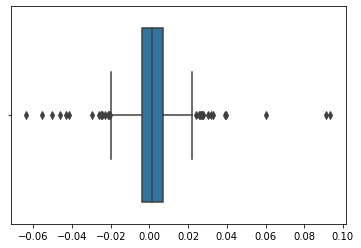

In [12]:
sns.boxplot(bt.profit_loss)
plt.show()

### Compare Profit Loss
To compare the profit and loss of different securities with our backtest, use ``compare_pl``.

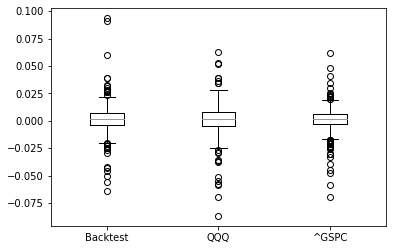

In [13]:
plt.boxplot(bt.compare_pl(['QQQ','^GSPC']), labels=['Backtest', 'QQQ', '^GSPC'])
plt.show()

# Custom DailyPriceProvider
To use your own data points, you can implement your own ``DailyPriceProvider``.
The following will show a price provider that simply returns random numbers and seeds them with the symbol name, which could definitely come in handy to make backtests more exiting and even less predictable.

In [18]:
from simple_back.price_providers import DailyPriceProvider
import numpy as np
import pandas as pd

In [25]:
def str_to_int(s):
    int.from_bytes(s.encode(), 'little')

In [127]:
class RandomPriceProvider(DailyPriceProvider):
    
    def __init__(self):
        self.symbols = {}
        self.drange = pd.date_range('2019-1-1','2020-1-1')
        super().__init__()
        
    def get_price(self, symbol, date=None, event=None):
        if symbol not in self.symbols:
            np.random.seed(str_to_int(symbol))
            self.symbols[symbol] = (np.random.rand(len(self.drange)*2)-.5).cumsum()
            self.symbols[symbol] = self.symbols[symbol]*100
            self.symbols[symbol] = self.symbols[symbol]+abs(self.symbols[symbol].min())
            self.symbols[symbol] = self.symbols[symbol]+np.random.randint(0,1_000)
        df = pd.DataFrame()
        df['date'] = self.drange
        df['open'] = self.symbols[symbol][::2]
        df['close'] = self.symbols[symbol][1::2]
        df.set_index('date')
        if date is not None:
            entry = df.loc[date]
        else:
            entry = df
        if event in ['open', 'close']:
            return df[event]
        if event is None:
            return entry
        raise Exception('event was neither "open" nor "close", but was still given')

In [128]:
random_price = RandomPriceProvider()

In [129]:
random_price['AAPL'].head()

,date,open,close
0,2019-01-01,630.207105,657.297222
1,2019-01-02,706.923784,754.434065
2,2019-01-03,785.283094,754.938398
3,2019-01-04,734.422808,767.068463
4,2019-01-05,792.167293,793.512683


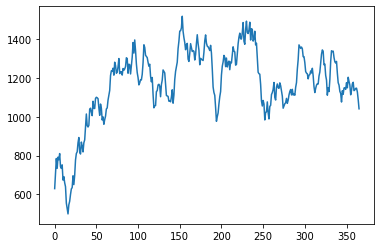

In [134]:
random_price['AAPL',:,'open'].plot()
plt.show()